<a href="https://colab.research.google.com/github/ChrisFJardine/Masterclass/blob/main/CJardineAssignment3__NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Load Libraries 
import requests
import numpy as np
import pandas as pd
import re
import time
import datetime
import os
import nltk
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import conlltags2tree, tree2conlltags
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
#from wordcloud import WordCloud
#import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score,precision_recall_curve, auc, ConfusionMatrixDisplay
from wordcloud import WordCloud
import seaborn
from pprint import pprint
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
nlp = en_core_web_sm.load()


%matplotlib inline 
from datetime import datetime, timedelta

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load raw corpus and sentiment and reshape
news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment 3/ExtractedNews.csv', header = None)
sentiment = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment 3/df_grouped_sentiment.csv')
docs = []
for x in range(news.shape[1]):
  for y in range(news.shape[0]):
    if isinstance(news[x][y], str):
      docs.append(news[x][y])
df = pd.DataFrame(docs)

In [ ]:
#Wrangle for NLP
df['date'] = df[0].apply(lambda x: datetime.strptime(re.search(r'\d{4}-\d{2}-\d{2}', str(x)).group(),'%Y-%m-%d').date()) #Remove exess date string
df['text'] = df[0].str.replace('[^\w\s]', '')                                  #remove punctuation
df['text'] = df['text'].str.replace('\d+','')                                  #remove numbers
df['text'] = df['text'].str.lstrip()                                           #remove leading spaces
#df['text'] = df['text'].str.lower()                                           #all to lower case
df = df.drop(df.columns[[0]], 1)
df.sort_values(by='date', inplace=True)
df['sentiment'] = df.apply(lambda x: sid.polarity_scores(x.text), axis=1)

df['compound']  = df['sentiment'].apply(lambda score_dict: score_dict['compound'])

In [ ]:
#ABC staff to exclude
ABC_staff = ['Grandstands Luke Pentony','Laura Tingle','Kerry Lonergan','Leigh Sales','John Barron','Mark Humphries','Shannon Byrne','Grandstands Alister Nicholson', 'Rachael','Richard Svenson','Zane Bojack','Lateline','Grandstands Dan Lonergan','Laurie Spina','Steve Mascord','Grandstands Craig Hamilton','Adam White']

In [ ]:
df2012 = df[( df['date'] > pd.Timestamp(2012,1,1))  &  (df['date'] < pd.Timestamp(2013,1,1)) ] 
listwords2012 = ' '.join([x for x in df2012.text]).split()

df2019 = df[( df['date'] > pd.Timestamp(2019,1,1))  &  (df['date'] < pd.Timestamp(2020,1,1)) ] 
listwords2019 = ' '.join([x for x in df2019.text]).split()

df2020 = df[( df['date'] > pd.Timestamp(2020,1,1))  &  (df['date'] < pd.Timestamp(2021,1,1)) ] 
listwords2020 = ' '.join([x for x in df2020.text]).split()

data = pd.concat([df2012, df2019, df2020])

In [ ]:
print('2012 corpus length : ' + str(len(df2012)))
print('2019 corpus length : ' + str(len(df2019)))
print('2020 corpus length : ' + str(len(df2020)))

2012 corpus length : 9280
2019 corpus length : 8749
2020 corpus length : 6484


In [ ]:
#Apply NER to a sentence / document
def extract_sent_named_enities(sent):
  list_ents = []
  ents = nlp(sent)
  for ent in ents.ents:
    if ent.label_ == 'PERSON' and ent.text not in ABC_staff:
      list_ents.append(ent.text)
  return(list_ents)

In [ ]:
#Extract the entities from each document
data['entities'] = data.apply(lambda x: extract_sent_named_enities(x.text), axis = 1)
data = data[data['entities'].apply(lambda x: len(x)) > 0]


In [ ]:
#Create a subset of data to apply. Split news into Good news and Bad News
data = data[['entities','compound']]
data = data.explode('entities')
data['good_news'] = 0
data.loc[data['compound'] > 0, 'good_news'] = 1 


In [ ]:
#data.to_csv('/content/drive/MyDrive/Colab Notebooks/Assignment 3/NER_data.csv', index=True) 
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment 3/NER_data.csv')

In [ ]:
#Redundant.
def extract_named_enities(df, stopnames = []):
  list_ents = []
  for text in df['text']:
    ents = nlp(text)
    for ent in ents.ents:
      if ent.label_ == 'PERSON' and ent.text not in stopnames:
        list_ents.append(ent.text)
  return(list_ents)

In [ ]:
def plot_entities(entity_list):
  fdist = FreqDist(entity_list).most_common(20)
  all_fdist = pd.Series(dict(fdist))
  fig, ax = plt.subplots(figsize=(20,10))
  all_plot = seaborn.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
  plt.xticks(rotation=60);

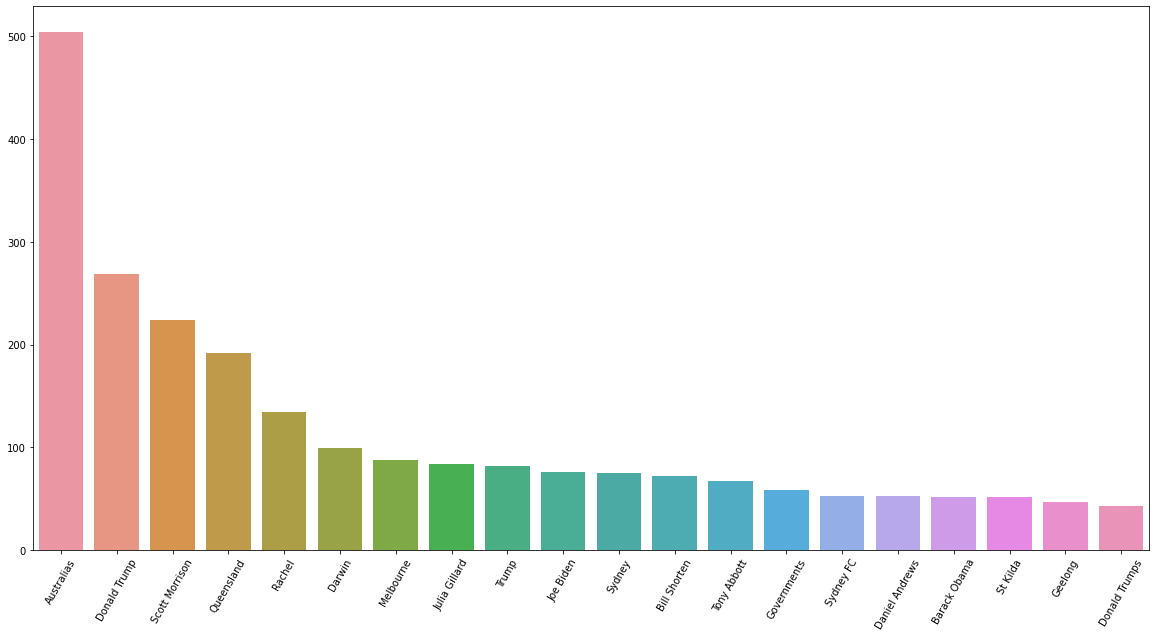

In [ ]:
#Get a list of entities and plot
entities = data['entities'].tolist()
plot_entities(entities)


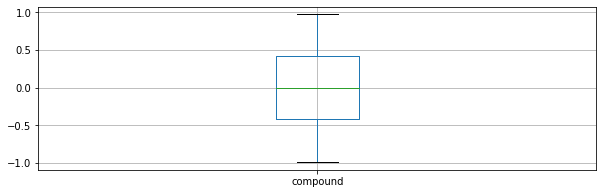

In [ ]:
#Review the spread of average sentiment 
data.boxplot(column = 'compound')

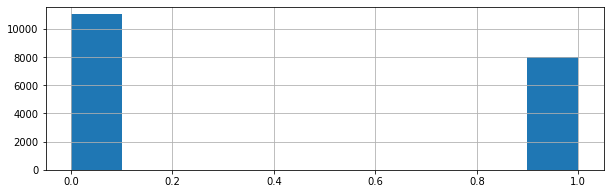

In [ ]:
#check the distribution
hist = ml_data['good_news']
hist.hist()

In [ ]:
#Binarise Data
mlb = MultiLabelBinarizer()
bin_data = pd.DataFrame(mlb.fit_transform(ml_data['entities']),columns=mlb.classes_, index=ml_data.index)
bin_data.shape
X = bin_data
y = ml_data['good_news']


In [ ]:
#Test Train Split. Fit OneVsRest SVC Classifier to test data
X = np.array(X)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 5)  #test / train split
clf = OneVsRestClassifier(SVC(kernel='poly'))
clf.fit(train_X, train_y)


OneVsRestClassifier(estimator=SVC(kernel='poly'))

In [ ]:
#Check performance on train data
pred_train = clf.predict(train_X)  
accuracy_score(train_y, pred_train)


0.6983609794628752

In [ ]:
#Check performance on test data
pred_test = clf.predict(test_X)  
accuracy_score(test_y, pred_test)

0.6030805687203792

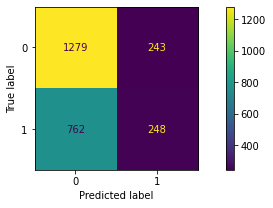

In [ ]:
#Review confustion matrix
cm = confusion_matrix(test_y, pred_test, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

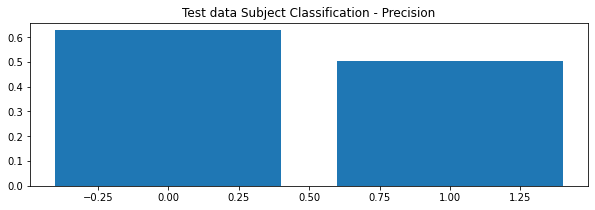

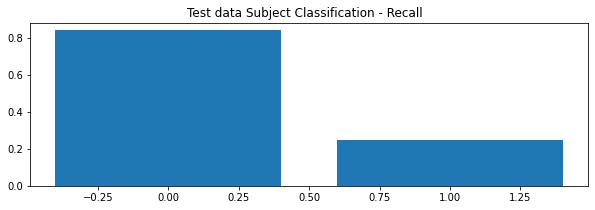

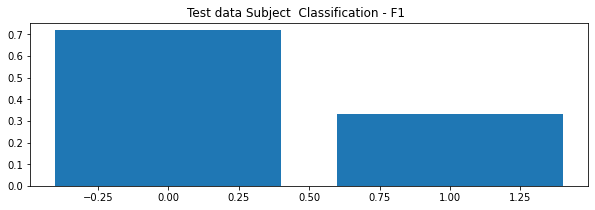

In [ ]:
#Visualise model peformance on test data
labels = list(set(test_y))
accuracy = accuracy_score(test_y, pred_test)
precision = precision_score(test_y, pred_test, average=None, zero_division = 1, pos_label=None, labels = labels)
recall = recall_score(test_y, pred_test, average=None, pos_label=None, labels = labels )
f1 = f1_score(test_y, pred_test, average=None, pos_label=None, labels = labels)
plt.rcParams["figure.figsize"] = (10,3)
plt.bar(labels, precision)
plt.title('Test data Subject Classification - Precision')
#plt.xticks(rotation = 'vertical')
plt.show()

plt.bar(labels, recall)
plt.title('Test data Subject Classification - Recall  ')
plt.show()

plt.bar(labels, f1)
plt.title('Test data Subject  Classification - F1       ')
plt.show()

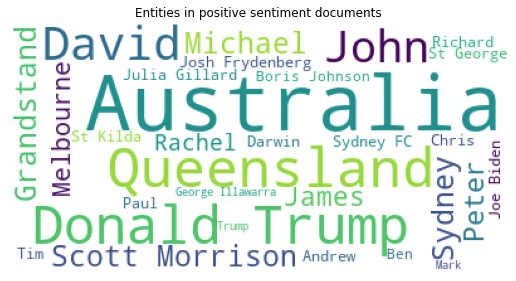

In [ ]:
good_news_people = data.loc[data['good_news'] == 1, 'entities'].to_list()
text = " ".join(word for word in good_news_people)

wordcloud = WordCloud(max_words = 30, background_color="white").generate(text)
plt.figure(figsize = [9,9])
plt.imshow(wordcloud, interpolation='antialiased')
plt.title('Entities in positive sentiment documents')
plt.axis("off")
plt.show()

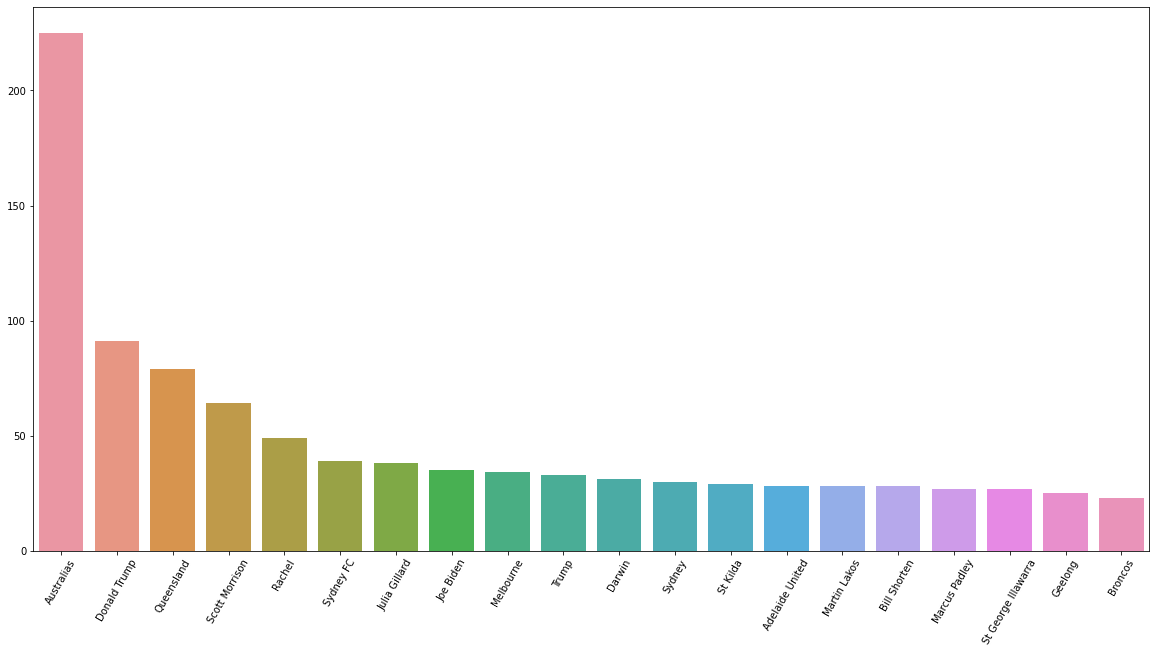

In [ ]:
plot_entities(data.loc[data['good_news'] == 1, 'entities'].to_list())

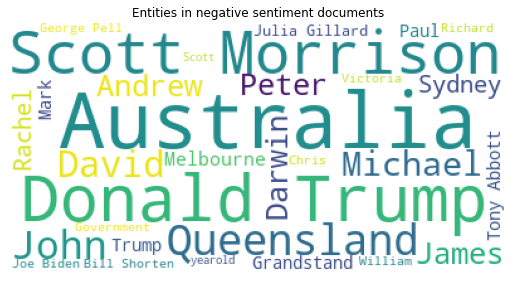

In [ ]:
good_news_people = data.loc[data['good_news'] == 0, 'entities'].to_list()
text = " ".join(word for word in good_news_people)

wordcloud = WordCloud(max_words = 30, background_color="white").generate(text)
plt.figure(figsize = [9,9])
plt.imshow(wordcloud, interpolation='antialiased')
plt.title('Entities in negative sentiment documents')
plt.axis("off")
plt.show()

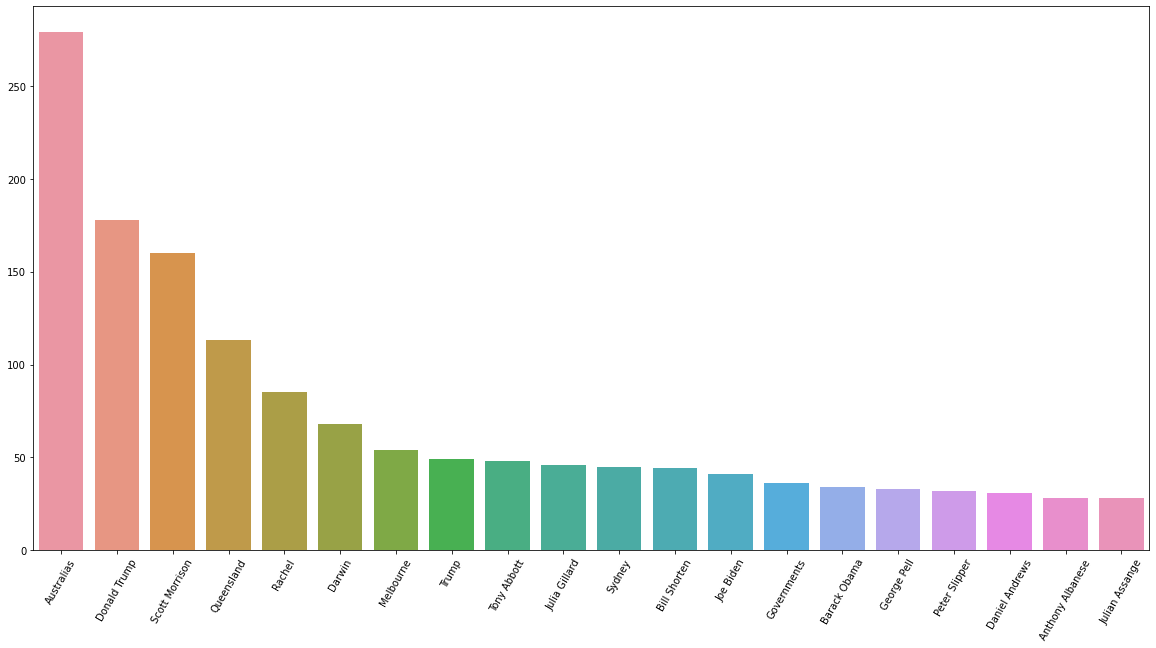

In [ ]:
plot_entities(data.loc[data['good_news'] == 0, 'entities'].to_list())